# [Taylor law](https://en.wikipedia.org/wiki/Taylor%27s_law)

In [1]:
import numpy as np
from scipy import stats
import os 
import pandas as pd
from plotnine import *

## Observations: Gene length distribution in different species

### Retrieve the statistical description and tax_id of species

##### Statistical description data file

In [2]:
# system
system = list(os.uname())[0]
if system == 'Linux':
    base_dir = "/media/emuro/Wes/"
elif system == 'Darwin':
    base_dir = "/Volumes/Wes/"
    
# statistics on length distribution for different species     
stat_file = base_dir + "results/geneLength/outputInputFiles/" + "analysis/some_statistics/stat_description/" 
#stat_file += "all__stat_description.ensembl.tsv"
stat_file += "all__stat_description.ensembl_v2.0__withLineage.tsv"
print(stat_file)

# retrieve data
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_7", "division_8", "species", "count", "mean", "var"] + ["log10_mean", "log10_var"]]
#stat_df = stat_df[["division_8"]] 
# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

/Volumes/Wes/results/geneLength/outputInputFiles/analysis/some_statistics/stat_description/all__stat_description.ensembl_v2.0__withLineage.tsv


,division_7,division_8,species,count,mean,var,log10_mean,log10_var
0,bacteria,archaea,methanobacterium_bryantii_gca_002287175,3168,840.404040,422343.848699,2.827684,0.082694
1,bacteria,archaea,methanobacterium_formicicum_gca_000762265,2352,862.427296,347239.612747,2.849723,0.076317


(33630, 8)


##### Filter some species

In [3]:
if 0:
    print(stat_df["division_8"].value_counts())
cond = stat_df["division_8"].isin(["bacteria", "archaea","protists", "plants", "fungi", "metazoa", "vertebrates"])  # avoid: empty or viruses
stat_df = stat_df[cond]

stat_df = stat_df[stat_df["species"] != "mus_caroli"]

if 1:
    #display(stat_df.head(2))
    print(stat_df.shape)
    print(stat_df["division_8"].value_counts())

(33460, 8)
bacteria       30555
archaea         1228
fungi           1007
protists         237
vertebrates      222
metazoa          115
plants            96
Name: division_8, dtype: int64


## Observed Taylor law: Variance vs Length (genes)
$\sigma^{2}$ is the variance  
$\sigma^{2} = a . \mu^{\beta}$  
Because: 
- $\log(\sigma^{2}) = \log(a) + \beta log(\mu) $

In [4]:
# FUNCTIONS
###########
def plot_taylor (df2plot, col_x, col_y, x_lab, y_lab, title, bool_show_regression): 
    #Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df2plot[col_x]),np.log10(df2plot[col_y]))
    #Format the regression text
    print('v = {:4.4} * m^{:4.4};   R^2= {:2.4f}'.format(10**intercept, slope, r_value**2))
    if bool_show_regression:
        txt = '$\sigma^{2} = ' + '{:4.4} '.format(10**intercept)  + '\t \mu^{' + '{:4.4}'.format(slope) + '}' + ';\tR^{2} = ' + '{:2.4f}$'.format(r_value**2)
    else:
        txt = ''
        
    p = (   
        ggplot(df2plot, aes(col_x, col_y, color=legends_by)) + geom_point(size=0.1) +
        geom_smooth(method="lm", color="green", size=0.25, span=.8)+
        labs(title=title, x=x_lab, y=y_lab) 
        + scale_color_manual(values=['#D83B01', '#002050', '#A80000', '#FFA500', '#107C10','#EF008C', '#0078D7', '#B4009E']) # + scale_color_brewer() '#5C2D91'
        + labs(color='Clade') # legend title
        + scale_x_log10(breaks=[10 ** power for power in range(6)],
          limits=[min(df2plot[col_x].to_list())/2, 2*max(df2plot[col_x].to_list())]) 
        + scale_y_log10(breaks = [10**power for power in range(13)], 
          limits = [min(df2plot[col_y].to_list())/2,2*max(df2plot[col_y].to_list())])#, labels=scientific_format(digits=2)
    ) + theme(legend_position=(0.8,0.3), legend_key_size=5, legend_background=element_rect(fill='grey', alpha=0.01)) + annotate('text', x=0.015*max(df2plot[col_x].to_list()), y=0.65*max(df2plot[col_y].to_list()), label=txt,size=9,color="black")
    print(p)

(33460, 8)
v = 0.01638 * m^2.508;   R^2= 0.9223


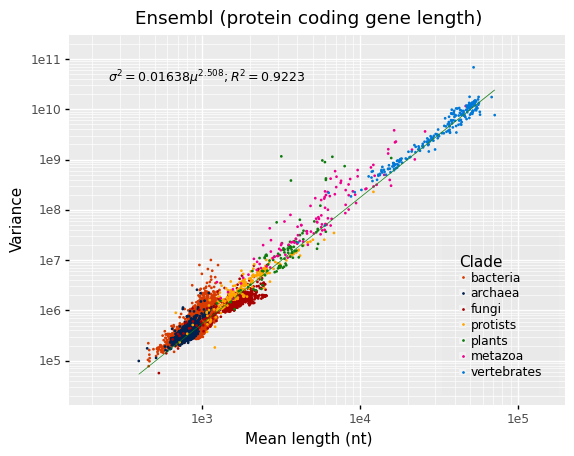

In [5]:
col_x = "mean"  # prots_mean
col_y = "var"   # prots_var
legends_by = "division_8"

title = "Ensembl (protein coding gene length)" # "Uniprot, reference Proteomes (protein length)"
x_lab = "Mean length (nt)"   # "mean length (aa)"
y_lab = "Variance"
bool_show_regression = True

df2plot = stat_df
print(df2plot.shape)

# Sort division_8 in order to plot the clades in an order (everything can be displayed)
if 0:
    print(df2plot.division_8.unique())
df2plot.division_8 = pd.Categorical(df2plot.division_8, 
                                categories=['bacteria', 'archaea', 'fungi', 'protists', 'plants', 'metazoa', 'vertebrates'],
                                ordered=True)
df2plot.sort_values('division_8', inplace=True)

plot_taylor(df2plot, col_x, col_y, x_lab, y_lab, title, bool_show_regression)

### Analyzing clade by clade:

In [6]:
for clado in stat_df["division_8"].unique().tolist(): # for each division
    df2plot = stat_df[stat_df["division_8"]==clado]
    if 0: # Set up to 1 for plotting by division 
        plot_taylor(df2plot, col_x, col_y, x_lab, y_lab, title, False) # False ->bool_show_regression = False